In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Following KFC slides 304 on GAN but use MNIST as input
# Use np.eye for one-hot encoding
# 0 -> [1,0,...,0], 1-> [0,1,0,..0],..., 9->[0,0,...,1] 

mnist_x = np.load('/kaggle/input/mnist-numpy/mnist.npz')
x_train = mnist_x['x_train']/255.
x_test = mnist_x['x_test']/255.
mnist = np.concatenate([x_train, x_test], axis=0)
mnist = np.expand_dims(mnist, -1)

print('mnist shape is now: ', mnist.shape)

mnist shape is now:  (70000, 28, 28, 1)


In [3]:
# NOTE: NEED to us tensor.keras to import stuff!!
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import SGD, Adam

latent_size = 100
img_shape = (28,28,1)

# Use CNN, i.e. DCGAN
# Discriminator
# input = image, output = binary classifier
discriminator = Sequential()
discriminator.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=img_shape))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.4))
discriminator.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.4))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(0.0002, 0.5),
                      metrics=['accuracy'])
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

2022-05-11 02:25:04.061490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 02:25:04.162885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 02:25:04.163687: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 02:25:04.164810: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [4]:
# Generator
# input = latent array (noise), output = image
# UpSampling2D is just a simple scaling up of the image by using nearest neighbour 
# or bilinear upsampling.Advantage is it's cheap.
# Conv2DTranspose is a convolution operation whose kernel is learnt during training
generator = Sequential()
n_nodes = 128*7*7
# Start with 7x7 image
generator.add(Dense(n_nodes, input_dim=latent_size))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Reshape((7, 7, 128)))
# Upsample to 14x14
generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator.add(LeakyReLU(alpha=0.2))
# Upsample to 28x28
generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Conv2D(1, (7,7), activation='softplus', padding='same'))
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)      

In [5]:
# Try another way to combine
def combined_gan(g,d):
    d.trainable = False
    model = Sequential()
    model.add(g)
    model.add(d)
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return model

In [6]:
#print(len(mnist))
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        os.remove(filename)
#os.remove("/kaggle/working/000.png")

In [7]:
# Training: ask the discriminator to separate real/fake
# images; ask the generator to generate cheat the discriminator.

combined = combined_gan(generator,discriminator)

#noise_test = np.random.randn(100, latent_size)
batch_size = 256
for epoch in range(1001):
    imgs_real = mnist[np.random.randint(0, len(mnist), batch_size)]
    
    noise = np.random.randn(batch_size, latent_size)
    imgs_fake = generator.predict(noise)

    X, y = np.vstack((imgs_real, imgs_fake)), np.vstack((np.ones((batch_size,1)), np.zeros((batch_size,1))))
    #dis_loss_real = discriminator.train_on_batch(imgs_real, np.ones((batch_size,1)))
    #dis_loss_fake = discriminator.train_on_batch(imgs_fake, np.zeros((batch_size,1)))
    #dis_loss = np.add(dis_loss_real,dis_loss_fake)*0.5
    dis_loss = discriminator.train_on_batch(X,y)
    
    # Training generator
    noise = np.random.randn(batch_size, latent_size)
    gen_loss = combined.train_on_batch(noise, np.ones((batch_size,1)))
    
    
    if epoch % 100 == 0:
        print("Epoch: %d, discriminator(loss: %.3f, acc.: %.2f%%), generator(loss: %.3f)" %
          (epoch, dis_loss[0], dis_loss[1]*100., gen_loss))
    
    #if epoch % 20 == 0:
        #imgs_fake = generator.predict(noise_test)
        imgs_fake = generator.predict(noise)
        
        fig = plt.figure(figsize=(10,10), dpi=80)
        plt.subplots_adjust(0.05,0.05,0.95,0.95,0.1,0.1)
        for i in range(100):
            plt.subplot(10,10,i+1)
            plt.axis('off')
            plt.imshow(imgs_fake[i], cmap='Greys')
        fig.suptitle('epoch: %04d' % epoch, color='Blue', fontsize=16)
        fig.savefig("%04d.png" % epoch)
        plt.close()
    

2022-05-11 02:25:06.870798: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-11 02:25:08.651209: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Epoch: 0, discriminator(loss: 0.690, acc.: 47.85%), generator(loss: 0.765)
Epoch: 100, discriminator(loss: 0.471, acc.: 75.59%), generator(loss: 2.581)
Epoch: 200, discriminator(loss: 0.528, acc.: 77.93%), generator(loss: 1.512)
Epoch: 300, discriminator(loss: 0.649, acc.: 64.06%), generator(loss: 0.793)
Epoch: 400, discriminator(loss: 0.725, acc.: 46.68%), generator(loss: 0.726)
Epoch: 500, discriminator(loss: 0.683, acc.: 56.25%), generator(loss: 0.732)


2022-05-11 02:26:28.658509: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch: 600, discriminator(loss: 0.699, acc.: 51.17%), generator(loss: 0.710)
Epoch: 700, discriminator(loss: 0.694, acc.: 53.32%), generator(loss: 0.717)
Epoch: 800, discriminator(loss: 0.689, acc.: 55.27%), generator(loss: 0.709)
Epoch: 900, discriminator(loss: 0.678, acc.: 56.64%), generator(loss: 0.722)
Epoch: 1000, discriminator(loss: 0.677, acc.: 55.86%), generator(loss: 0.723)


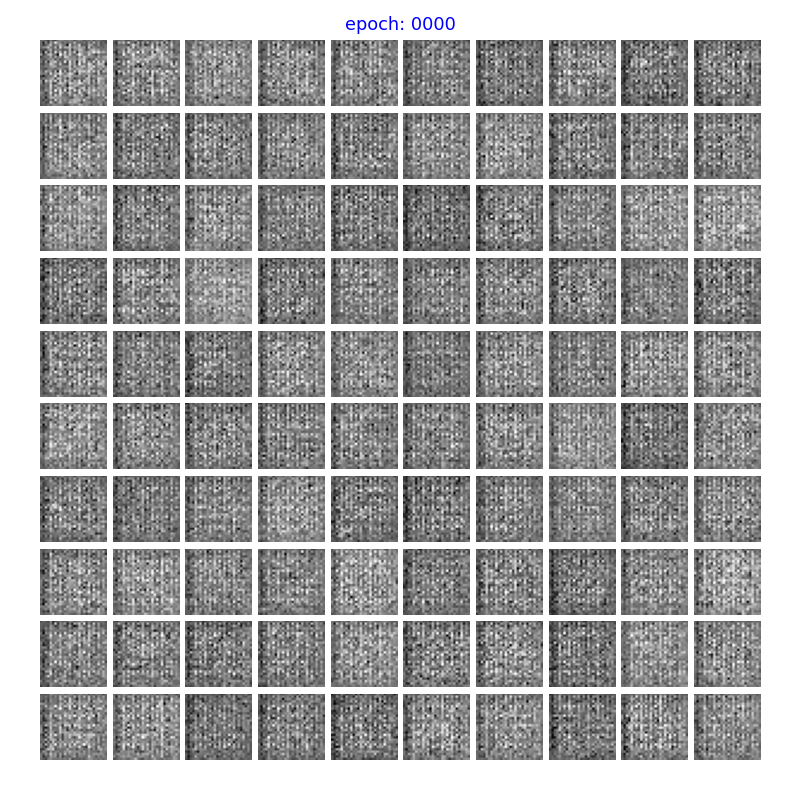

In [8]:
from IPython.display import Image
Image("/kaggle/working/0000.png")

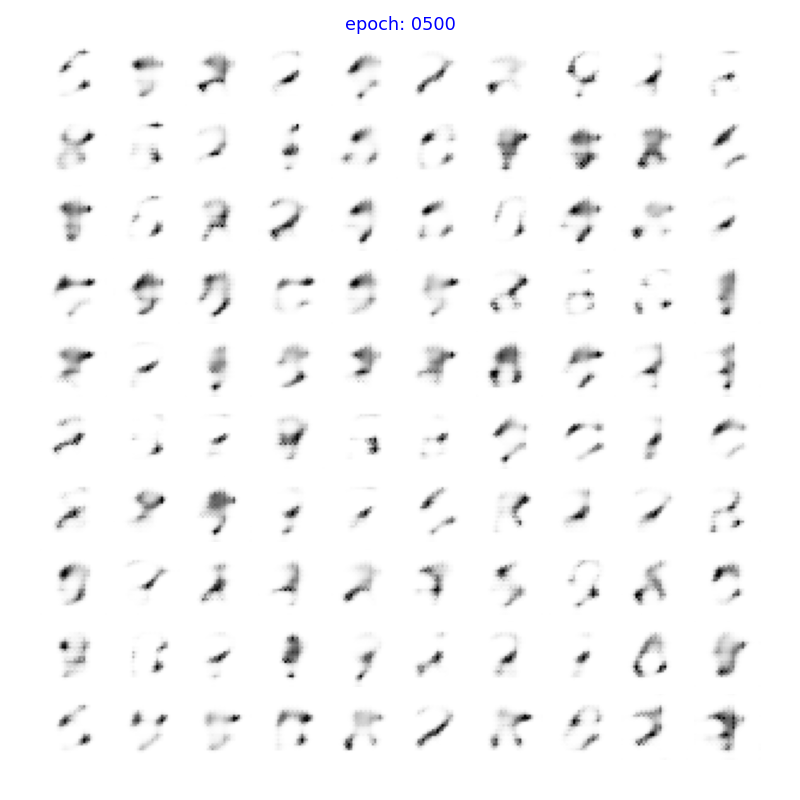

In [9]:
Image("/kaggle/working/0500.png")

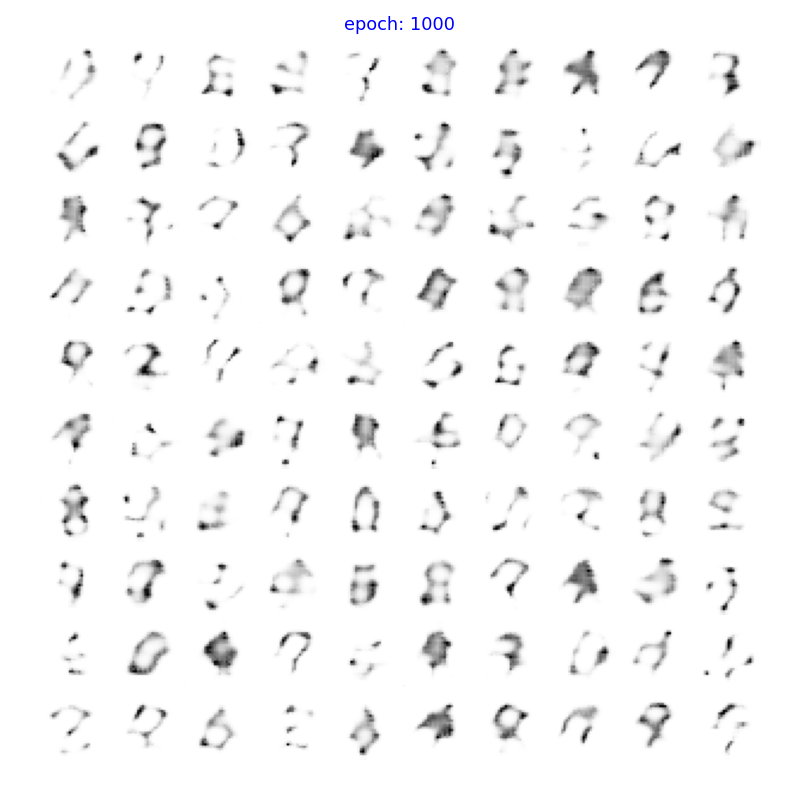

In [10]:
Image("/kaggle/working/1000.png")